In [1]:
import numpy as np
import pandas as pd
import os
import sys
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

# manifest_file = os.path.join(drive_path,'manifest.json')
manifest_file = r"/Volumes/programs/braintv/workgroups/nc-ophys/ObservatoryPlatformPaperAnalysis/platform_boc_pre_2018_3_16/manifest.json"
print(manifest_file)

boc = BrainObservatoryCache(manifest_file=manifest_file)

/Volumes/programs/braintv/workgroups/nc-ophys/ObservatoryPlatformPaperAnalysis/platform_boc_pre_2018_3_16/manifest.json


In [7]:
save_path = r'/Volumes/programs/braintv/workgroups/nc-ophys/ObservatoryPlatformPaperAnalysis/analysis_files_pre_2018_3_29'

In [4]:
exps = boc.get_ophys_experiments(stimuli=['drifting_gratings'], targeted_structures=['VISp'])

In [5]:
len(exps)

130

In [12]:
exps[0]

{'acquisition_age_days': 100,
 'cre_line': u'Cux2-CreERT2',
 'donor_name': u'222420',
 'experiment_container_id': 511509529,
 'fail_eye_tracking': True,
 'id': 501271265,
 'imaging_depth': 175,
 'reporter_line': u'Ai93(TITL-GCaMP6f)',
 'session_type': u'three_session_A',
 'specimen_name': u'Cux2-CreERT2;Camk2a-tTA;Ai93-222420',
 'targeted_structure': u'VISp'}

In [6]:
session_id = exps[0]['id']

In [13]:
data_file_dg = os.path.join(save_path, 'DriftingGratings', str(session_id)+"_dg_events_analysis.h5")


In [14]:
print data_file_dg

/Volumes/programs/braintv/workgroups/nc-ophys/ObservatoryPlatformPaperAnalysis/analysis_files_pre_2018_3_29/DriftingGratings/501271265_dg_events_analysis.h5


In [19]:
f = h5py.File(data_file_dg)
response = f['response_events'].value
f.close()
peak = pd.read_hdf(data_file_dg, 'peak')

In [25]:
response.shape[2]

215

In [22]:
peak.head()

,cell_specimen_id,pref_ori_dg,pref_tf_dg,num_pref_trials_dg,responsive_dg,g_osi_dg,g_dsi_dg,tfdi_dg,reliability_dg,lifetime_sparseness_dg,fit_tf_dg,fit_tf_ind_dg,tf_low_cutoff_dg,tf_high_cutoff_dg,run_pval_dg,run_resp_dg,stat_resp_dg,run_mod_dg,peak_blank_dg,all_blank_dg
0,517409604,135,1,9,True,0.48814,0.402039,0.389594,0.0272313,0.635982,1,0,NaN,2,0.451895,0.0019288,0.00263953,-0.269265,0.00193954,-5.67049e-05
1,517409609,90,1,11,True,0.661482,0.494014,0.330799,0.0434076,0.824654,1,0,NaN,2.63902,0.103735,0.0127155,0.00145322,0.885713,0.00623315,0.000150812
2,517409646,270,1,1,False,0.37074,0.2252,0.221185,0.0396332,0.603798,NaN,NaN,NaN,NaN,0.317407,0.0056926,0.000223535,0.960732,0.00356037,0.000246847
3,517409467,45,1,5,True,0.142899,0.318665,0.402895,-0.00497152,0.412832,1,0,NaN,2.46229,0.123644,0.00298977,0.00117611,0.606622,0.00154481,0.00019124
4,517410060,270,1,3,False,0.234929,0.110082,0.353882,0.0264039,0.484035,NaN,NaN,NaN,NaN,0.453721,0.00108925,0.000617463,0.433129,0.000649775,-6.10378e-05


In [26]:
numbercells = response.shape[2]
dgtf = pd.DataFrame(columns=('cell_specimen_id','cre','area','depth','pref_dir','pref_tf','pref_null_tf','pref_response','null_response','DSI_pref_tf','DSI_null_tf','DSI_tuning','tf_tuning_pref','tf_tuning_null', 'tf_sem_pref','tf_sem_null'), index=range(numbercells))

In [46]:
def get_dsi(pref_ori, null_ori, tf, nc):
    pref = response[pref_ori, tf, nc, 0]
    pref = np.where(pref>0, pref, 0)
    null = response[null_ori, tf, nc, 0]
    null = np.where(null>0, null, 0)
    return ((pref - null) / (pref + null))

In [42]:
orivals = np.array(range(0,360,45))
tfvals = np.array([0,1,2,4,8,15])

In [37]:
orivals

[0, 45, 90, 135, 180, 225, 270, 315]

In [33]:
peak.pref_ori_dg.iloc[0]

135

In [39]:
peak.pref_ori_dg.iloc[0] in orivals

True

In [41]:
np.where(orivals==peak.pref_ori_dg.iloc[0])[0][0]

3

In [47]:
a=0
dgtf.cell_specimen_id = peak.cell_specimen_id
dgtf.cre = exps[a]['cre_line']
dgtf.area = exps[a]['targeted_structure']
dgtf.depth = exps[a]['imaging_depth']
for i in range(numbercells):
    pref_ori = np.where(orivals==peak.pref_ori_dg.iloc[i])[0][0]
    pref_tf = np.where(tfvals==peak.pref_tf_dg.iloc[i])[0][0]
    null_ori = np.mod(pref_ori+4,8)
    dgtf.pref_dir.loc[i] = peak.pref_ori_dg.iloc[i]
    dgtf.pref_tf.loc[i] = peak.pref_tf_dg.iloc[i]
    null_tf = np.argmax(response[null_ori,1:,i,0])
    dgtf.pref_null_tf.loc[i] = tfvals[null_tf+1]
    dgtf.pref_response.loc[i] = response[pref_ori, pref_tf, i, 0]
    dgtf.null_response.loc[i] = response[null_ori, null_tf+1, i, 0]
    dgtf.tf_tuning_pref.loc[i] = response[pref_ori,1:,i,0]
    dgtf.tf_tuning_null.loc[i] = response[null_ori,1:,i,0]
    dgtf.tf_sem_pref.loc[i] = response[pref_ori,1:,i,1]
    dgtf.tf_sem_null.loc[i] = response[null_ori,1:,i,1]
    dgtf.DSI_pref_tf.loc[i] = get_dsi(pref_ori, null_ori, pref_tf, i)
    dgtf.DSI_null_tf.loc[i] = get_dsi(pref_ori, null_ori, null_tf+1, i)
    dsi_tuning = np.empty((5))
    for a in range(5):
        dsi_tuning[a] = get_dsi(pref_ori, null_ori, a+1, i)
    dgtf.DSI_tuning.loc[i] = dsi_tuning
#     dgtf.DSI_pref_tf.loc[i] = (response[pref_ori,pref_tf,i,0] - response[null_ori,pref_tf,i,0])/(response[pref_ori,pref_tf,i,0] + response[null_ori,pref_tf,i,0])
#     dgtf.DSI_null_tf.loc[i] = (response[pref_ori,null_tf+1,i,0] - response[null_ori,null_tf+1,i,0])/(response[pref_ori,null_tf+1,i,0] + response[null_ori,null_tf+1,i,0])

/Users/saskiad/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  


In [48]:
dgtf

,cell_specimen_id,cre,area,depth,pref_dir,pref_tf,pref_null_tf,pref_response,null_response,DSI_pref_tf,DSI_null_tf,DSI_tuning,tf_tuning_pref,tf_tuning_null,tf_sem_pref,tf_sem_null
0,517409604,Cux2-CreERT2,VISp,175,135,1,15,0.00230786,0.000418255,0.720829,-0.00721089,"[0.720828717208, 0.472483194944, 0.36385612447...","[0.00230785573812, 0.00105163225232, 0.0008481...","[0.000374405099397, 0.000376747040471, 0.00039...","[0.00046595379931, 0.000473850155841, 0.000247...","[0.000126427721668, 0.000259486802566, 0.00017..."
1,517409609,Cux2-CreERT2,VISp,175,90,1,1,0.00670893,0.0013236,0.670441,0.670441,"[0.670441056063, 0.834831702867, 0.74495952595...","[0.00670892919444, 0.00495411698494, 0.0019643...","[0.00132359511414, 0.000445960828409, 0.000287...","[0.00303497721867, 0.00138655929893, 0.0006739...","[0.00105106888422, 0.000173400636086, 0.000155..."
2,517409646,Cux2-CreERT2,VISp,175,270,1,1,0.00386958,0.000985357,0.59408,0.59408,"[0.594079972321, -0.225359013292, 1.0, 1.0, 0....","[0.00386957634354, 0.000312713837915, 0.000365...","[0.000985357424815, 0.000494663626694, 0.0, 0....","[0.00345023493113, 0.000217743905745, 0.000221...","[0.000345712383236, 0.000309307475972, 0.0, 0...."
3,517409467,Cux2-CreERT2,VISp,175,45,1,1,0.00178066,0.000565596,0.517874,0.517874,"[0.517874003449, 0.30595144139, 0.241891673596...","[0.00178066077391, 0.000941294418073, 0.000673...","[0.000565595595016, 0.000500251397859, 0.00041...","[0.000473058399506, 0.00017667027048, 0.000232...","[0.000167142246078, 0.000240614292997, 0.00016..."
4,517410060,Cux2-CreERT2,VISp,175,270,1,1,0.000931985,0.000739882,0.114904,0.114904,"[0.114903760857, -0.634777374775, 0.5964535704...","[0.000931985492235, 7.18486194213e-05, 0.00027...","[0.000739881667884, 0.000321602467444, 6.97787...","[0.000375558316841, 7.18486194213e-05, 0.00012...","[0.000264448225657, 0.000121963067966, 6.97787..."
5,587178258,Cux2-CreERT2,VISp,175,90,1,1,0.00374121,0.00349878,0.0334846,0.0334846,"[0.0334845540107, 0.814839948894, 0.1354925992...","[0.0037412112955, 0.00148435337946, 0.00158287...","[0.00349878330525, 0.000151441975789, 0.001205...","[0.00126119445442, 0.000574156880933, 0.001228...","[0.00142308790287, 0.000104294150724, 0.000517..."
6,587179547,Cux2-CreERT2,VISp,175,135,1,1,0.000913368,0.000774072,0.0825491,0.0825491,"[0.082549103441, 0.198546710335, -0.1556139956...","[0.000913368355238, 0.000770218932281, 9.00357...","[0.000774071692211, 0.000515035827736, 0.00012...","[0.00028667659882, 0.000392900267273, 9.003573...","[0.000274421162338, 0.000150780523709, 8.40215..."
7,587179579,Cux2-CreERT2,VISp,175,225,4,8,0.00359354,0.000806574,0.858736,-0.712795,"[0.182892509357, 0.12996903179, 0.858735726764...","[0.000806329851271, 0.000404640179736, 0.00359...","[0.000556989038472, 0.000311556757263, 0.00027...","[0.000291619765245, 0.000163398252307, 0.00235...","[0.000135613429703, 0.000105778330513, 0.00014..."
8,587179599,Cux2-CreERT2,VISp,175,315,2,8,0.00327682,0.00066686,0.830903,0.243065,"[0.710185411575, 0.830903450691, 0.86003684815...","[0.00293918621373, 0.00327682387974, 0.0010119...","[0.000498085784775, 0.000302637263886, 7.61478...","[0.00155765004896, 0.00122417812907, 0.0006915...","[0.000177212434223, 0.000115838609852, 7.61478..."
9,517409091,Cux2-CreERT2,VISp,175,0,1,8,0.00145684,0.00134993,0.0584757,-0.353157,"[0.0584757286563, -0.325309794465, -0.23333876...","[0.00145683778169, 0.000334458473486, 0.000625...","[0.00129587112272, 0.000656984623633, 0.001006...","[0.000479915780732, 0.000151393964928, 0.00021...","[0.000325206900867, 0.000245072169476, 0.00027..."


In [326]:
subset = dgtf[(dgtf.pref_response>4)&(dgtf.null_response>4)]

In [327]:
len(subset)

22

In [ ]:
i=9
plt.plot(subset.DSI_tuning.iloc[i], 'o-')
plt.ylabel("DSI")
plt.xlabel("TF")
plt.axhline(y=0, ls='--', color='k')
plt.xticks(range(5), dg.tfvals[1:])

In [ ]:
dgtf

In [ ]:
np.argmax(dg.response[6,1:,0,0])

In [ ]:
dg.orivals[dg.peak.ori_dg[0]]

Text(0.5,1,u'670050073')

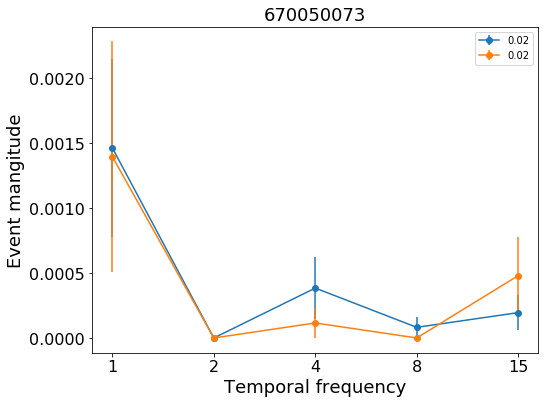

In [103]:
i=2
plt.figure(figsize=(8,6))
plt.errorbar(range(5), dgtf.tf_tuning_pref.loc[i], yerr=dgtf.tf_sem_pref.loc[i], fmt='o-', label=np.round(dgtf.DSI_pref_tf.loc[i],2))
plt.errorbar(range(5), dgtf.tf_tuning_null.loc[i], yerr=dgtf.tf_sem_null.loc[i], fmt='o-', label=np.round(dgtf.DSI_null_tf.loc[i],2))
plt.xticks(range(5), tfvals[1:])
plt.xlabel("Temporal frequency", fontsize=18)
plt.ylabel("Event mangitude", fontsize=18)
plt.tick_params(labelsize=16)
plt.legend()
plt.title(str(dgtf.cell_specimen_id.loc[i]), fontsize=18)

In [ ]:
np.round(0.12345,2)

In [ ]:
len(exps)

In [50]:
for a in range(130):
    session_id = exps[a]['id']
    data_file_dg = os.path.join(save_path, 'DriftingGratings', str(session_id)+"_dg_events_analysis.h5")
    f = h5py.File(data_file_dg)
    response = f['response_events'].value
    f.close()
    peak = pd.read_hdf(data_file_dg, 'peak')
    numbercells = response.shape[2]
    
    print a, numbercells
    dgtf = pd.DataFrame(columns=('cell_specimen_id','cre','area','depth','responsive_dg','pref_dir','pref_tf','pref_null_tf','pref_response','null_response','DSI_pref_tf','DSI_null_tf','DSI_tuning','tf_tuning_pref','tf_tuning_null', 'tf_sem_pref','tf_sem_null'), index=range(numbercells))
    dgtf.cell_specimen_id = peak.cell_specimen_id
    dgtf.responsive_dg = peak.responsive_dg
    dgtf.cre = exps[a]['cre_line']
    dgtf.area = exps[a]['targeted_structure']
    dgtf.depth = exps[a]['imaging_depth']
    for i in range(numbercells):
        pref_ori = np.where(orivals==peak.pref_ori_dg.iloc[i])[0][0]
        pref_tf = np.where(tfvals==peak.pref_tf_dg.iloc[i])[0][0]
        null_ori = np.mod(pref_ori+4,8)
        dgtf.pref_dir.loc[i] = peak.pref_ori_dg.iloc[i]
        dgtf.pref_tf.loc[i] = peak.pref_tf_dg.iloc[i]
        null_tf = np.argmax(response[null_ori,1:,i,0])
        dgtf.pref_null_tf.loc[i] = tfvals[null_tf+1]
        dgtf.pref_response.loc[i] = response[pref_ori, pref_tf, i, 0]
        dgtf.null_response.loc[i] = response[null_ori, null_tf+1, i, 0]
        dgtf.tf_tuning_pref.loc[i] = response[pref_ori,1:,i,0]
        dgtf.tf_tuning_null.loc[i] = response[null_ori,1:,i,0]
        dgtf.tf_sem_pref.loc[i] = response[pref_ori,1:,i,1]
        dgtf.tf_sem_null.loc[i] = response[null_ori,1:,i,1]
        dgtf.DSI_pref_tf.loc[i] = get_dsi(pref_ori, null_ori, pref_tf, i)
        dgtf.DSI_null_tf.loc[i] = get_dsi(pref_ori, null_ori, null_tf+1, i)
        dsi_tuning = np.empty((5))
        for b in range(5):
            dsi_tuning[b] = get_dsi(pref_ori, null_ori, b+1, i)
        dgtf.DSI_tuning.loc[i] = dsi_tuning

    if a==0:
        dgtf_all = dgtf.copy()
    else:
        dgtf_all = dgtf_all.append(dgtf)
        

0 215

/Users/saskiad/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in double_scalars
  



1 205
2 178
3 142
4 292
5 197
6 266
7 226
8 240
9 184
10 353
11 318
12 264
13 254
14 230
15 378
16 226
17 167
18 171
19 290
20 334
21 415
22 256
23 209
24 302
25 315
26 352
27 320
28 485
29 160
30 221
31 221
32 143
33 371
34 54
35 60
36 70
37 99
38 52
39 173
40 81
41 51
42 58
43 45
44 86
45 35
46 14
47 71
48 129
49 48
50 21
51 46
52 79
53 66
54 48
55 21
56 49
57 28
58 23
59 55
60 227
61 284
62 90
63 211
64 171
65 237
66 157
67 240
68 130
69 83
70 53
71 150
72 208
73 213
74 109
75 144
76 110
77 224
78 207
79 244
80 86
81 107
82 211
83 309
84 198
85 214
86 155
87 261
88 261
89 89
90 8
91 8
92 10
93 15
94 10
95 11
96 10
97 14
98 15
99 17
100 5
101 124
102 13
103 6
104 7
105 7
106 7
107 15
108 127
109 128
110 171
111 172
112 139
113 103
114 11
115 13
116 13
117 24
118 9
119 17
120 8
121 9
122 12
123 9
124 13
125 9
126 4
127 4
128 12
129 10


In [8]:
print a

4


In [97]:
len(dgtf_all)

17164

In [59]:
dgtf_all.to_csv(r'/Users/saskiad/Documents/Data/CAM/Direction tuning TF/dgtf_events_all.csv')

In [2]:
dgtf_all = pd.read_csv(r'/Users/saskiad/Documents/Data/CAM/Direction tuning TF/dgtf_events_all.csv')

In [ ]:
dgtf_all

In [52]:
dgtf_all.shape

(17164, 16)

In [58]:
dgtf_all = dgtf_all.reset_index()

In [55]:
dgtf_all.cre.unique()

array([u'Cux2-CreERT2', u'Emx1-IRES-Cre', u'Fezf2-CreER', u'Nr5a1-Cre',
       u'Ntsr1-Cre_GN220', u'Rbp4-Cre_KL100', u'Rorb-IRES2-Cre',
       u'Scnn1a-Tg3-Cre', u'Slc17a7-IRES2-Cre', u'Sst-IRES-Cre',
       u'Tlx3-Cre_PL56', u'Vip-IRES-Cre'], dtype=object)

In [64]:
dgtf_all.pref_response.mean()

0.0085891703639139234

In [92]:
dgtf_all[dgtf_all.cell_specimen_id==529022196]

,index,cell_specimen_id,cre,area,depth,pref_dir,pref_tf,pref_null_tf,pref_response,null_response,DSI_pref_tf,DSI_null_tf,DSI_tuning,tf_tuning_pref,tf_tuning_null,tf_sem_pref,tf_sem_null,DSI_ratio
3080,0,529022196,Cux2-CreERT2,VISp,275,90,15,8,0.0123231,0.00446745,0.687608,-0.114908,"[0.299772369272, 0.506908524231, 0.51308905975...","[0.000716312148471, 0.00216572189734, 0.003132...","[0.000385899539368, 0.00070866876741, 0.001007...","[0.000209911652109, 0.00071032575029, 0.001614...","[0.000172192671464, 0.000339083896498, 0.00035...",-0.167112


In [93]:
dgtf_all[dgtf_all.cell_specimen_id==529023544]

,index,cell_specimen_id,cre,area,depth,pref_dir,pref_tf,pref_null_tf,pref_response,null_response,DSI_pref_tf,DSI_null_tf,DSI_tuning,tf_tuning_pref,tf_tuning_null,tf_sem_pref,tf_sem_null,DSI_ratio
3098,18,529023544,Cux2-CreERT2,VISp,275,315,2,2,0.00337337,0.0023381,0.181262,0.181262,"[0.14912042768, 0.181261860181, 0.249683465741...","[0.0029487587975, 0.00337337471174, 0.00317289...","[0.00218344271327, 0.00233810184643, 0.0019050...","[0.000952287292933, 0.000926053302935, 0.00077...","[0.000666896648323, 0.000829554916576, 0.00049...",1


In [9]:
subset = dgtf_all[(dgtf_all.pref_response>.003)&(dgtf_all.null_response>.003)]

In [4]:
len(dgtf_all[dgtf_all.pref_response>.003])

9721

In [5]:
len(subset)

4029

In [ ]:
for i in range(1696):
    if np.mod(i,50)==0:
        print i
    plt.figure(figsize=(8,6))
    plt.errorbar(range(5),subset.tf_tuning_pref.iloc[i], subset.tf_sem_pref.iloc[i], fmt='o-', label=np.round(subset.DSI_pref_tf.iloc[i],2))
    plt.errorbar(range(5),subset.tf_tuning_null.iloc[i], subset.tf_sem_null.iloc[i], fmt='o-', label=np.round(subset.DSI_null_tf.iloc[i],2))
    plt.xticks(range(5), dg.tfvals[1:])
    plt.xlabel("Temporal frequency", fontsize=18)
    plt.ylabel("DF/F", fontsize=18)
    plt.tick_params(labelsize=16)
    plt.legend()
    plt.title(str(subset.cell_specimen_id.iloc[i]), fontsize=18)
    plt.savefig(os.path.join('DGTF', str(subset.cell_specimen_id.iloc[i])+'.png'))
    plt.close()

a lot of cells like 117 where TF tuning is mostly same except at the preferred TF.
Cell 169 is good example

In [ ]:
potential_cells.append(i)

In [ ]:
potential_cells

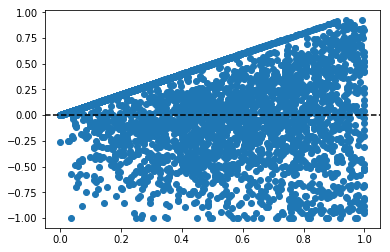

In [71]:
plt.plot(subset.DSI_pref_tf, subset.DSI_null_tf, 'o')
# plt.plot([-5,5],[-5,5], color='k')
# plt.xlim(-2,5)
# plt.ylim(-2,5)
plt.axhline(y=0, ls='--', color='k')

([<matplotlib.axis.XTick at 0x11c09b290>,
 <a list of 5 Text xticklabel objects>)

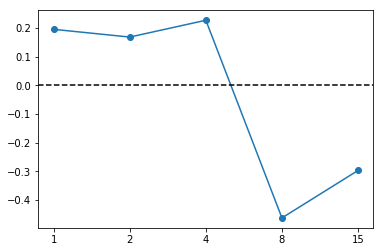

In [99]:
i=7
plt.plot(subset.DSI_tuning.iloc[i], 'o-')
plt.axhline(y=0, ls='--', color='k')
plt.xticks(range(5), tfvals[1:])

In [80]:
def dsi_dif(f):
    return f['DSI_pref_tf']/f['DSI_null_tf']

In [89]:
dsi_dif(subset.DSI_tuning.iloc[i])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [7]:
dgtf_all['DSI_ratio'] = dgtf_all.DSI_null_tf/dgtf_all.DSI_pref_tf

In [10]:
print(len(subset[subset.DSI_ratio<0.]))
print(len(subset[subset.DSI_ratio>0.]))

1382
2647


In [85]:
temp =  subset[(subset.DSI_ratio>-10)&(subset.DSI_ratio<0)]

/Users/saskiad/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:29: RuntimeWarning: tp_compare didn't return -1 or -2 for exception
  return umr_minimum(a, axis, None, out, keepdims)


index                          0
cell_specimen_id       517397474
cre                 Cux2-CreERT2
area                        VISp
depth                        175
pref_dir                       0
pref_tf                        1
pref_null_tf                   1
pref_response         0.00302528
null_response         0.00300252
DSI_pref_tf          0.000252124
DSI_null_tf                   -1
DSI_ratio               -215.236
dtype: object

In [86]:
len(temp)

1375

In [87]:
subset[subset.depth==175].DSI_ratio.mean()

0.16278285500999254

In [88]:
subset[subset.depth==275].DSI_ratio.mean()

0.083585050027383409

In [89]:
subset[subset.depth==300].DSI_ratio.mean()

-0.81540043314004496

In [107]:
import seaborn as sns

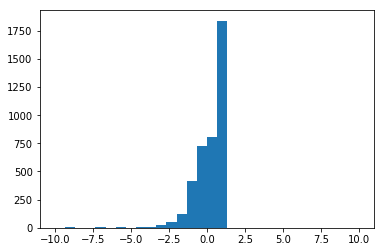

In [14]:
plt.hist(subset[subset.DSI_ratio>-200].DSI_ratio.astype(float), bins=30, range=(-10,10));

In [225]:
dgtf_all['DSI_ratio'] = dgtf_all.DSI_ratio.astype(float)

In [161]:
subset[subset.DSI_ratio<-200]

,index,cell_specimen_id,cre,area,depth,pref_dir,pref_tf,pref_null_tf,pref_response,null_response,DSI_pref_tf,DSI_null_tf,DSI_tuning,tf_tuning_pref,tf_tuning_null,tf_sem_pref,tf_sem_null,DSI_ratio
7003,90,562753338,Emx1-IRES-Cre/wt,VISp,275,0,8,15,71.6773,68.6458,0.374727,-3.28466e-05,"[1.0, 0.104306565148, 0.178326673774, 0.374727...","[8.38656664689, 7.62295820415, 9.96962172699, ...","[-0.527647112993, 6.18291499217, 6.95203836759...","[2.78957331093, 2.21673629476, 2.86904944321, ...","[3.49797365006, 1.96842663283, 3.82506941262, ...",-11408.396246


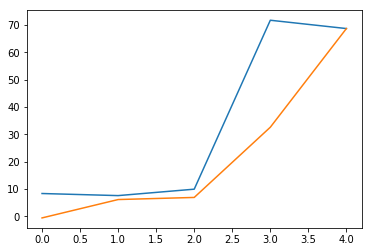

In [160]:
plt.plot(subset[subset.DSI_ratio<-200].tf_tuning_pref.iloc[0])
plt.plot(subset[subset.DSI_ratio<-200].tf_tuning_null.iloc[0])

In [16]:
print(subset[(np.abs(subset.DSI_ratio)<10)&(subset.depth==175)].DSI_ratio.mean())
print(subset[(np.abs(subset.DSI_ratio)<10)&(subset.depth==275)].DSI_ratio.mean())
print(subset[(np.abs(subset.DSI_ratio)<10)&(subset.depth==375)].DSI_ratio.mean())

0.205903362879
0.226394983631
0.240043175114


In [17]:
for depth in subset.depth.unique():
    print(depth, subset[(np.abs(subset.DSI_ratio)<10)&(subset.depth==depth)].DSI_ratio.mean())

(175, 0.20590336287899982)
(275, 0.2263949836305001)
(375, 0.2400431751139141)
(400, 0.34659192468362365)
(300, -0.2652155350782901)
(335, -0.275887512096496)
(350, 0.11118535760209601)
(550, 0.23956935163370885)
(265, -0.18461696602856378)
(285, 0.3757821583850868)


Text(0,0.5,u'DSI ratio null:pref')

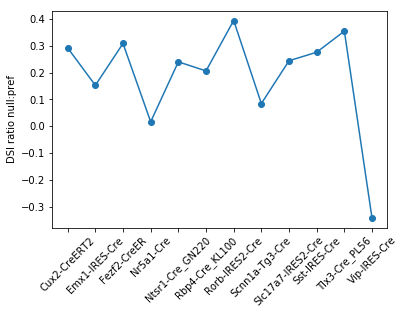

In [18]:
plt.plot(subset[np.abs(subset.DSI_ratio)<10].groupby('cre').DSI_ratio.mean(), 'o-')
plt.xticks(rotation=45)
plt.ylabel("DSI ratio null:pref")

In [23]:
subset.cre.unique()

array(['Cux2-CreERT2', 'Emx1-IRES-Cre', 'Fezf2-CreER', 'Nr5a1-Cre',
       'Ntsr1-Cre_GN220', 'Rbp4-Cre_KL100', 'Rorb-IRES2-Cre',
       'Scnn1a-Tg3-Cre', 'Slc17a7-IRES2-Cre', 'Sst-IRES-Cre',
       'Tlx3-Cre_PL56', 'Vip-IRES-Cre'], dtype=object)

([<matplotlib.axis.XTick at 0x1089fe7d0>,
 <a list of 12 Text xticklabel objects>)

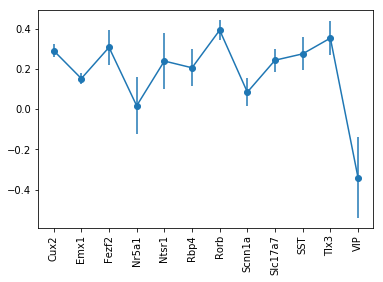

In [25]:
plt.errorbar(range(12), subset[np.abs(subset.DSI_ratio)<10].groupby('cre').DSI_ratio.mean(), 
             yerr=subset[np.abs(subset.DSI_ratio)<10].groupby('cre').DSI_ratio.std()/np.sqrt(subset[np.abs(subset.DSI_ratio)<10].groupby('cre').DSI_ratio.count()), 
             fmt='o-')
plt.xticks(range(12),['Cux2','Emx1','Fezf2','Nr5a1','Ntsr1','Rbp4','Rorb','Scnn1a','Slc17a7','SST','Tlx3','VIP'], rotation=90)

In [26]:
subset[np.abs(subset.DSI_ratio)<10].groupby('cre').DSI_ratio.count()

cre
Cux2-CreERT2          792
Emx1-IRES-Cre        1656
Fezf2-CreER           137
Nr5a1-Cre              67
Ntsr1-Cre_GN220        58
Rbp4-Cre_KL100        159
Rorb-IRES2-Cre        260
Scnn1a-Tg3-Cre        177
Slc17a7-IRES2-Cre     360
Sst-IRES-Cre          153
Tlx3-Cre_PL56         163
Vip-IRES-Cre           40
Name: DSI_ratio, dtype: int64

In [287]:
subset.DSI_ratio.min()

-4.7734853795382524

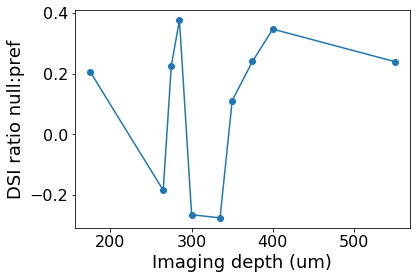

In [27]:
plt.plot(subset[np.abs(subset.DSI_ratio)<10].groupby('depth').DSI_ratio.mean(), 'o-')
plt.xlabel("Imaging depth (um)", fontsize=18)
plt.ylabel("DSI ratio null:pref", fontsize=18)
plt.tick_params(labelsize=16)

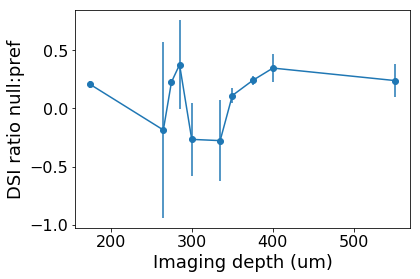

In [28]:
plt.errorbar(np.sort(subset.depth.unique()), subset[np.abs(subset.DSI_ratio)<10].groupby('depth').DSI_ratio.mean(), 
                     yerr=subset[np.abs(subset.DSI_ratio)<10].groupby('depth').DSI_ratio.std()/np.sqrt(subset[np.abs(subset.DSI_ratio)<20].groupby('depth').DSI_ratio.count()), 
                     fmt='o-')
plt.xlabel("Imaging depth (um)", fontsize=18)
plt.ylabel("DSI ratio null:pref", fontsize=18)
plt.tick_params(labelsize=16)

In [233]:
subset[subset.depth==335].cre.unique()

array([u'Scnn1a-Tg3-Cre/wt', u'Nr5a1-Cre/wt'], dtype=object)

In [290]:
temp = subset[(np.abs(subset.DSI_ratio)<20)&(subset.depth==335)]

1.0


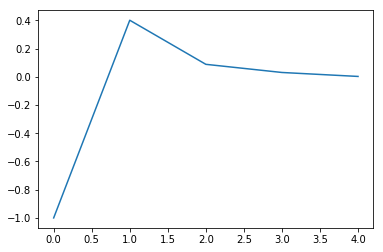

In [291]:
plt.plot(temp.DSI_tuning.iloc[0])
print(temp.DSI_ratio.iloc[0])

In [134]:
temp = subset[np.abs(subset.DSI_ratio)<20]
for i in range(len(temp)):
    plt.figure(figsize=(8,12))
    plt.subplot(211)
    plt.errorbar(range(5),temp.tf_tuning_pref.iloc[i], temp.tf_sem_pref.iloc[i], fmt='o-', label=np.round(temp.DSI_pref_tf.iloc[i],2))
    plt.errorbar(range(5),temp.tf_tuning_null.iloc[i], temp.tf_sem_null.iloc[i], fmt='o-', label=np.round(temp.DSI_null_tf.iloc[i],2))
    plt.xticks(range(5), tfvals[1:])
    # plt.xlabel("Temporal frequency", fontsize=18)
    plt.ylabel("Event magnitude", fontsize=18)
    plt.tick_params(labelsize=16)
    plt.legend()
    plt.title(str(temp.cell_specimen_id.iloc[i])+'_'+str(temp.cre.iloc[i].split('-')[0])+'_'+str(temp.depth.iloc[i]), fontsize=18)
    plt.subplot(212)
    plt.plot(temp.DSI_tuning.iloc[i], 'o-')
    plt.xticks(range(5), tfvals[1:])
    plt.xlabel("Temporal frequency", fontsize=18)
    plt.ylabel("DSI", fontsize=18)
    plt.axhline(y=0, ls='--', color='k')
    plt.tick_params(labelsize=16)
    plt.title("DSI ratio = "+str(np.round(temp.DSI_ratio.iloc[i],3)), fontsize=16)
    plt.savefig(os.path.join(r'/Users/saskiad/Documents/Data/CAM/Direction tuning TF/event plots', str(temp.cell_specimen_id.iloc[i])+'.png'))
    plt.close()


In [319]:
len(temp)

2018

In [318]:
temp[temp.cell_specimen_id==517515242]

,index,cell_specimen_id,cre,area,depth,pref_dir,pref_tf,pref_null_tf,pref_response,null_response,DSI_pref_tf,DSI_null_tf,DSI_tuning,tf_tuning_pref,tf_tuning_null,tf_sem_pref,tf_sem_null,DSI_ratio
8665,223,517515242,Cux2-CreERT2/wt,VISp,275,90,4,15,17.8061,14.3291,0.952983,-0.42607,"[0.84729959494, 0.81371685525, 0.952982630848,...","[4.89902514418, 7.00923695564, 17.8061282396, ...","[0.404960368077, 0.719904376815, 0.42867626746...","[2.46498998786, 1.82674123072, 3.5240180176, 2...","[1.79670560444, 0.618170357933, 1.11282114124,...",-0.447091


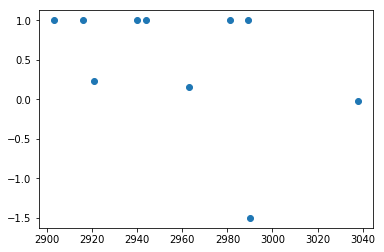

In [229]:
plt.plot(temp.DSI_ratio, 'o')

In [236]:
temp

,index,cell_specimen_id,cre,area,depth,pref_dir,pref_tf,pref_null_tf,pref_response,null_response,DSI_pref_tf,DSI_null_tf,DSI_tuning,tf_tuning_pref,tf_tuning_null,tf_sem_pref,tf_sem_null,DSI_ratio
5301,8,539773178,Scnn1a-Tg3-Cre/wt,VISp,335,180,15,15,32.5997,32.428,0.0026394,0.0026394,"[-1.0, 0.400853932411, 0.08843313769, 0.030701...","[-0.941105145216, 5.57227147023, 13.2616020759...","[1.81433422963, 2.38326385192, 11.1066418091, ...","[1.27382054324, 1.00580269348, 2.06698088098, ...","[0.733997107681, 1.36642296391, 2.56752580952,...",1.000000
5319,26,539773009,Scnn1a-Tg3-Cre/wt,VISp,335,90,15,8,13.5514,4.71987,0.748489,-0.485277,"[nan, -0.154539294355, nan, -0.48527693499, 0....","[-3.87585828404, 0.733032538866, -0.8073008159...","[-3.59809341431, 1.00101029476, -0.39374880393...","[5.56181817892, 2.23579949399, 6.0729946971, 5...","[5.15553081449, 6.89375351197, 3.76362700801, ...",-0.648342
5336,43,539773276,Scnn1a-Tg3-Cre/wt,VISp,335,180,2,1,14.5134,6.08405,0.938457,-0.832464,"[-0.83246443421, 0.938457456745, 0.89689810344...","[0.55624268204, 14.5133895953, 2.50846243302, ...","[6.08405103013, 0.460774057146, 0.136342186132...","[0.698700637051, 6.65658364106, 1.38673052516,...","[6.06505010319, 0.491558169938, 0.588934535378...",-0.887056
6679,14,541281363,Nr5a1-Cre/wt,VISp,335,270,15,15,5.32891,4.99755,0.0320885,0.0320885,"[-1.0, nan, -1.0, 1.0, 0.0320885128212]","[-0.621756440401, -0.00428652923022, -0.687000...","[0.499405058225, -1.63294031459, 0.81130771562...","[0.893205198952, 0.418825984802, 0.71614240815...","[0.432488621588, 1.05821423606, 0.257297972834...",1.000000
6705,40,541281543,Nr5a1-Cre/wt,VISp,335,0,1,2,24.943,6.4008,0.685253,-0.943777,"[0.685253320379, -0.943776875976, nan, nan, nan]","[24.9429576159, 0.185140986244, -1.39803754712...","[4.65847655932, 6.4007963645, -0.527628253897,...","[18.4434383864, 0.324709200453, 1.5051682535, ...","[2.15275258964, 4.0137658447, 0.531508599175, ...",-1.377267


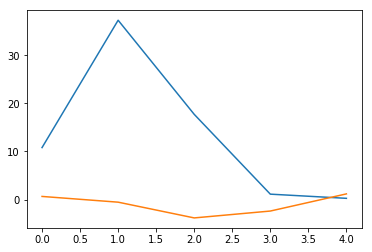

In [289]:
plt.plot(subset[(np.abs(subset.DSI_ratio<20))&(subset.depth==275)].tf_tuning_pref.iloc[1])
plt.plot(subset[(np.abs(subset.DSI_ratio<20))&(subset.depth==275)].tf_tuning_null.iloc[1])
print subset

In [321]:
dgtf_all.to_csv('dgtf_all.csv')

In [322]:
len(subset)

2045

In [341]:
subset[subset.DSI_ratio<0.3].cell_specimen_id.values;

In [339]:
subset[subset.DSI_ratio>0.6].cell_specimen_id.values;

In [96]:
peak

,cell_specimen_id,pref_ori_dg,pref_tf_dg,num_pref_trials_dg,responsive_dg,g_osi_dg,g_dsi_dg,tfdi_dg,reliability_dg,lifetime_sparseness_dg,fit_tf_dg,fit_tf_ind_dg,tf_low_cutoff_dg,tf_high_cutoff_dg,run_pval_dg,run_resp_dg,stat_resp_dg,run_mod_dg,peak_blank_dg,all_blank_dg
0,670050036,270,4,2,False,0.144064,0.116159,0.264099,-0.0213555,0.346501,NaN,NaN,NaN,NaN,0.296473,0.000325043,0.00158386,-0.794778,0.000220041,-0.00045962
1,670050098,180,1,1,False,0.401658,0.216572,0.328234,-0.0189113,0.668243,NaN,NaN,NaN,NaN,0.66334,0.00145675,0.00218924,-0.334585,-2.32791e-05,-0.00164077
2,670050073,180,1,0,False,0.351182,0.13115,0.353991,0.0409238,0.627547,NaN,NaN,NaN,NaN,0.823513,0.00164571,0.00136018,0.1735,-0.000460046,-0.00163479
3,670050087,315,1,1,False,0.476703,0.445172,0.233235,-0.0413054,0.583641,NaN,NaN,NaN,NaN,0.391966,0.004199,0.000261455,0.937734,0.000813232,-0.00073382
4,670050143,180,1,1,False,0.565705,0.136085,0.281874,-0.0242517,0.588047,NaN,NaN,NaN,NaN,0.38456,0.0039509,0.000555048,0.859513,-0.00020442,-0.0016277
5,670049985,180,1,2,False,0.313226,0.0405329,0.293663,-0.0169492,0.343037,NaN,NaN,NaN,NaN,0.159014,0.00211329,0.000735425,0.652,0.000622585,-0.000164646
6,670049965,0,1,2,False,0.715624,0.099611,0.348002,0.0476332,0.762640,NaN,NaN,NaN,NaN,0.201028,0.0104477,0.00126846,0.878589,0.00277226,-0.000528328
7,670049916,0,1,2,False,0.520003,0.102366,0.281878,-0.0263909,0.643982,NaN,NaN,NaN,NaN,0.523901,0.00458815,0.00174802,0.619015,0.00015544,-0.00191658
8,670050110,0,1,1,False,0.580484,0.0506534,0.275485,0.0669137,0.700305,NaN,NaN,NaN,NaN,0.310185,0.0197272,0.00126272,0.935991,-0.000144696,-0.00536992
9,670050121,180,1,1,False,0.540381,0.201476,0.346861,0.0337769,0.738543,NaN,NaN,NaN,NaN,0.168481,0.0133157,0.00149458,0.887758,-0.000717347,-0.00578718


Text(0.5,1,u'587178397')

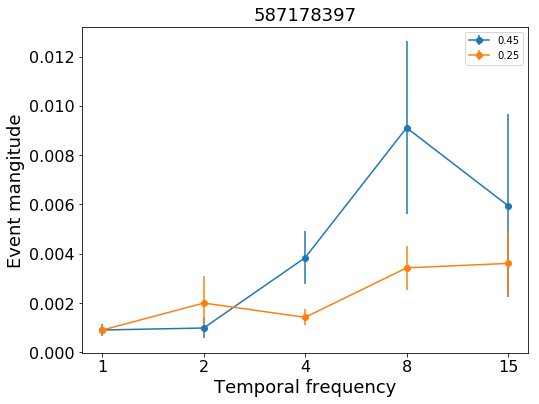

In [132]:
i=26
plt.figure(figsize=(8,6))
plt.errorbar(range(5), subset.tf_tuning_pref.iloc[i], yerr=subset.tf_sem_pref.iloc[i], fmt='o-', label=np.round(subset.DSI_pref_tf.iloc[i],2))
plt.errorbar(range(5), subset.tf_tuning_null.iloc[i], yerr=subset.tf_sem_null.iloc[i], fmt='o-', label=np.round(subset.DSI_null_tf.iloc[i],2))
plt.xticks(range(5), tfvals[1:])
plt.xlabel("Temporal frequency", fontsize=18)
plt.ylabel("Event mangitude", fontsize=18)
plt.tick_params(labelsize=16)
plt.legend()
plt.title(str(subset.cell_specimen_id.iloc[i]), fontsize=18)